<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/transfer-learning/MNIST_to_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task:

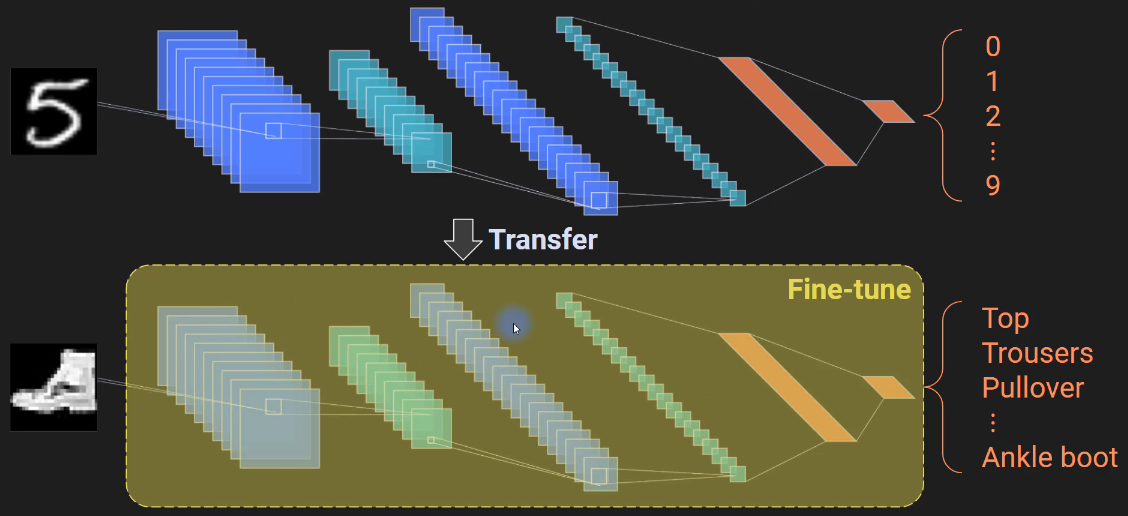

In [60]:
# for importing data:
import torchvision
import torchvision.transforms as T

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import copy # for copying and replacing

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

# Impor & process data:

In [61]:
# 1. training data (MNIST):

# split cols into (labels + data), np array -> torch tensor
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array, (20000, 785)
labelsT   = torch.tensor( data[:,0] ).long() # torch tensor, [20000], long: no decimals
data      = data[:,1:] # np array, (20000, 784)
dataNorm  = data / np.max(data) # normalize, (20000, 784)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float() # reshape, float: with decimals
# 👆 NOTE: no need to normalize lables, normalize data only

# split (rows) into (train + test)
train_data, test_data, train_labels, test_labels = train_test_split(dataNormT, labelsT, test_size=.1)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

# torch tensor -> torch Dataset obj
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# torch Dataset obj -> torch dataloader obj
batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 1, 28, 28]) torch.Size([2000, 1, 28, 28]) torch.Size([18000]) torch.Size([2000])


In [62]:
# 2. target data (FMNIST):

# transformations
transform = T.Compose([
    T.ToTensor(), # convert to tensor & normalize from [0, 255] -> [0, 1]
    # torchvision.transforms.Normalize(mean, std, inplace=False)
    # normalize pixel values from [0, 1] to [-1,1] by subtracting 0.5 from each pixel value and then dividing by 0.5
    T.Normalize(.5,.5) # (mean, std)
])

# import the data and simultaneously apply the transformations
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform) # `train=True` -> train set
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform) # train=False -> test set

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True) # w/ mini-batches
fashion_test_loader  = DataLoader(testset, batch_size=len(testset)) # wo/ no mini-batch

# Create the DL model:

In [63]:
def createTheMNISTNet(printtoggle=False): # introduce variable

  # create a class for the model
  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # --------- (convolutional + pooling) layers ---------

      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      # --------- fc layers ---------

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)

      ### fc1 layer
      self.fc1 = nn.Linear(expectSize,50)

      ### fc2 layer (output)
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # --------- (convolutional + pooling) layers ---------

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # --------- fc layers ---------

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x) # output
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create an model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss() # for categorical data

  # optimizer (Using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.005)

  return net,lossfun,optimizer

# Create a function to train the model:

In [64]:
# a function that trains the model:
def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochi in range(numepochs):
    net.train()
    batchAcc  = []
    batchLoss = []

    # loop over training batches
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # record loss from this batch
      batchLoss.append(loss.item())

      # compute ave accuracy for the batch, then record it
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average accuracy x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # record ave accuracies across batches
    trainAcc.append( np.mean(batchAcc) )

    # record ave losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval() # switch to evaluation/test mode
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compute test accuracy
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Train the model using MNIST data & show results:

In [65]:
# create a new model
numberNet,lossfun,optimizer = createTheMNISTNet()

# train the model with MNIST data
trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,5)

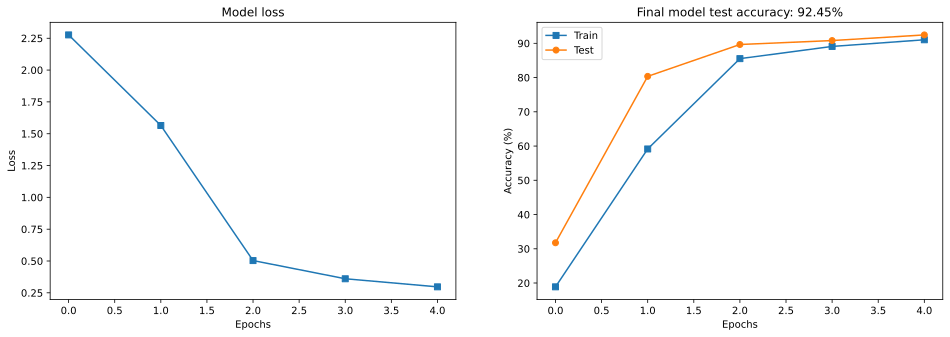

In [66]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Test the model with FMNIST data:

In [67]:
# test the model with fashion data

# extract X,y from FASHION test dataloader
X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 6.49%


👆 Dismal performance (just as expected).
Even pure chance level performance would be somewhere around 10%.

# Transfer weights from SOURCE model to TARGET model:

In [68]:
# NOTE: I've added print() statements to show whether copying works.
#  - 1st print function will show a non-zeros matrix because the weights of the two models are differ.
#  - 2nd print function shows the zeros matrix because the two models have identical weights.

# create the target model
fashionNet,lossfun,optimizer = createTheMNISTNet()
print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] )

# transfer weights from SOURCE model to TARGET model
for target,source in zip(fashionNet.named_parameters(),numberNet.named_parameters()): # named params: weight matrices and bias vectors across layers
  target[1].data = copy.deepcopy( source[1].data ) # tuple[1] is the tensor (ref to the scratch in the following block)
print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] ) #

tensor([[[-0.1072, -0.3323,  0.0249, -0.2615, -0.1223],
         [ 0.0497,  0.1221, -0.1697, -0.5048, -0.1732],
         [-0.0814, -0.5016, -0.1276, -0.3572,  0.0746],
         [-0.1928, -0.0406, -0.1557, -0.4405, -0.4069],
         [-0.1184, -0.2985, -0.2287, -0.2244, -0.3166]]],
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)


In [69]:
# scratch:

for tp in fashionNet.named_parameters(): # tp: tuple
  print(tp)
  print("\n------------------\n")

('conv1.weight', Parameter containing:
tensor([[[[ 1.5386e-01,  2.1964e-01, -9.2753e-02,  1.3678e-01,  2.8719e-01],
          [-1.7011e-01, -1.4740e-02,  3.6684e-01,  4.5071e-01,  2.8307e-01],
          [ 1.3432e-01,  3.5796e-01,  2.9031e-01,  4.3034e-01,  5.2355e-02],
          [ 2.8402e-01,  5.1723e-02,  3.4096e-01,  2.9007e-01,  2.5282e-01],
          [ 1.5403e-01,  1.0659e-01,  3.1381e-01,  3.6415e-01,  1.8349e-01]]],


        [[[ 6.5187e-02, -5.7003e-02,  1.9276e-01, -7.3598e-02,  6.0606e-02],
          [-6.1820e-02,  2.0598e-01, -6.8510e-02, -3.9394e-02,  5.3821e-02],
          [ 1.0409e-02,  2.6727e-01,  1.4217e-01, -1.6093e-01, -9.7630e-03],
          [ 1.7393e-01,  1.6239e-01,  4.5263e-02,  8.6084e-02, -1.0537e-01],
          [ 2.4857e-01,  2.3262e-01, -3.8224e-02,  9.7146e-02, -7.9340e-02]]],


        [[[ 2.6631e-01,  1.4751e-01,  2.7008e-02,  2.6116e-01, -2.8027e-02],
          [ 3.2630e-01,  1.2703e-01,  3.1132e-01,  3.0114e-01, -1.1960e-01],
          [ 2.5487e-01,  2.68

In [70]:
# scratch:
print(fashionNet, "\n")
print(fashionNet.conv1, "\n") # inputs: (inChas, outChans, k, s, p), outputs: weights and biases
print(fashionNet.conv1.weight)
print(fashionNet.conv1.bias)

mnistNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
) 

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)) 

Parameter containing:
tensor([[[[ 1.5386e-01,  2.1964e-01, -9.2753e-02,  1.3678e-01,  2.8719e-01],
          [-1.7011e-01, -1.4740e-02,  3.6684e-01,  4.5071e-01,  2.8307e-01],
          [ 1.3432e-01,  3.5796e-01,  2.9031e-01,  4.3034e-01,  5.2355e-02],
          [ 2.8402e-01,  5.1723e-02,  3.4096e-01,  2.9007e-01,  2.5282e-01],
          [ 1.5403e-01,  1.0659e-01,  3.1381e-01,  3.6415e-01,  1.8349e-01]]],


        [[[ 6.5187e-02, -5.7003e-02,  1.9276e-01, -7.3598e-02,  6.0606e-02],
          [-6.1820e-02,  2.0598e-01, -6.8510e-02, -3.9394e-02,  5.3821e-02],
          [ 1.0409e-02,  2.6727e-01,  1.4217e-01, -1.6093e-01, -9.7630e-03],
   

In [71]:
# scratch:

fashionNet.conv1.weight[0]

tensor([[[ 0.1539,  0.2196, -0.0928,  0.1368,  0.2872],
         [-0.1701, -0.0147,  0.3668,  0.4507,  0.2831],
         [ 0.1343,  0.3580,  0.2903,  0.4303,  0.0524],
         [ 0.2840,  0.0517,  0.3410,  0.2901,  0.2528],
         [ 0.1540,  0.1066,  0.3138,  0.3641,  0.1835]]],
       grad_fn=<SelectBackward0>)

# Fine-tune the model with only one epoch of training:

In [72]:
# re-train (fine-tune) the network with the FMNIST data:
# function2trainTheModel(net,train_loader,test_loader,numepochs=10)
trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
    fashionNet,fashion_train_loader,fashion_test_loader,1 # NOTE: reset numepochs to 1
)

In [73]:
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

numberNet TRAIN accuracy: 66.83%
numberNet TEST accuracy: 74.93%


👆 Accuracies are significantly improved!